# Pythonで推論を実行する
trainingで作成したモデルを用いて、Pythonで推論を実行し、翻訳の精度を評価する

# 推論
Greedyサーチで推論する。

In [6]:
!python generate.py --test_file='../dataset/test.jsonl' --model_file='../training/model/checkpoint_best.pt' --outfile="outfile.txt" --device="cpu" --max_len=100  --search='greedy'

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/analysis01/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/analysis01/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 評価
BlueScoreでGreedyサーチで推論した翻訳結果と，実際の翻訳との比較を行い，評価する。

In [1]:
# https://thepythoncode.com/article/bleu-score-in-python

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import pandas as pd
from nltk.tokenize import word_tokenize

In [2]:
df = pd.read_csv('outfile.txt',sep='\t')



In [3]:
tgt=df['tgt'].tolist()
pred=df['pred'].tolist()

In [4]:

score=[]
tokenizer=lambda x: word_tokenize(x, language='english')

for t,p in zip(tgt,pred):
    ref = tokenizer(t)
    hyp = tokenizer(p)
    s=sentence_bleu([ref],hyp, smoothing_function=SmoothingFunction().method3)
    score.append(s)

In [5]:
import statistics

statistics.mean(score)

0.44819367141404437

In [6]:
statistics.median(score)

0.33970731016136024

In [7]:
max(score)

1.0

In [8]:
min(score)

0

In [9]:
import scipy

scipy.stats.mstats.mquantiles(score)

array([0.156197  , 0.33970731, 0.70710678])

In [10]:
import matplotlib.pyplot as plt

(array([1866., 2626., 1686., 1514., 1098.,  858.,  489.,  285.,   84.,
        3078.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

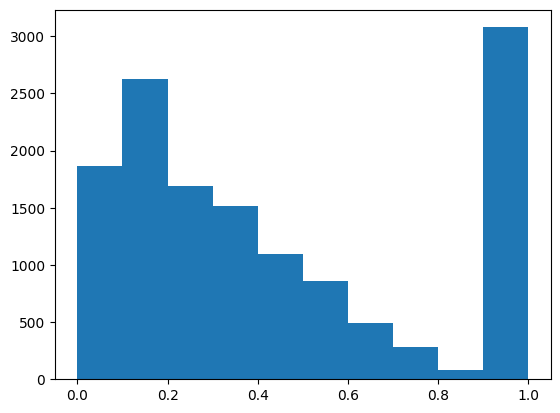

In [11]:
plt.hist(score)